# Mapa Litoestratigráfico Preditivo - Diamantina (MG)

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: _Franco Naghetini_ & _Guilherme Silveira_

## Introdução

O trabalho tem como objetivo a produção de um **mapa litoestratigráfico preditivo 1:25.000**, a partir de dados de sensores remotos e dados do mapeamento geológico realizado pelos alunos da disciplina de Estágio Supervisionado do ano de 2018, na região de Diamantina. As predições das unidades litoestratigráficas serão realizadas, utilizando algoritmos de *Machine Learning* (aprendizado supervisionado).

O produto gráfico final (*i.e.*, mapa litoestratigráfico preditivo) pode ser utilizado como um meio de reconciliação entre os dados de mapeamento de campo e os sensores remotos. Nesse sentido, as inconsistências entre o mapa geológico e o mapa litoestratigráfico preditivo podem fornecer *insights* e orientar futuras campanhas de mapeamento na região de Diamantina (MG).

## Contexto geológico

##  Configurações iniciais

##### Importação de bibliotecas

In [44]:
import os                              # Sistema operacional
from math import ceil
import pandas as pd                    # Manipulação de dataframes e series
import numpy as np                     # Operações numéricas
import matplotlib.pyplot as plt        # Visualização de dados
import seaborn as sns                  # Visualização de dados
import statistics as stats             # Ferramentas estatísticas
import scipy.stats as st               # Ferramentas estatísticas
import geopandas as gpd                # Manipulação de dataframes e series geoespaciais
import rasterio, folium                # Manipulação de rasters e mapas interativos
import warnings                        # Desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

##### Importação do banco de dados

In [2]:
df_original = pd.read_csv("data/dados.csv",sep=",")

In [151]:
# criação de uma cópia (deep) do dataframe original
df = df_original.copy(deep=True)

## Visualização geoespacial

##### Polígono da área

In [4]:
# importação do polígono da área
pol = "shp/poligono_Sirgas.shp"
# transformação do polígono em (geo)dataframe
gdf = gpd.read_file(pol)
# modificação do crs (31983 -> 4326)
gdf_wgs = gdf.to_crs("EPSG:4326")

# mapa interativo
pol_map = folium.Map(location=[-18.3,-43.7], zoom_start=12,
                     tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                     attr = 'Google', name = 'Google Satellite', overlay = True, 
                     control = True)

# polígono sobre mapa interativo
folium.Choropleth(geo_data=gdf_wgs.geometry, fill_opacity=0.1).add_to(pol_map)

pol_map

##### Unidades litoestratigráficas

In [5]:
# importação do shapefile de unidades litoestratigráficas
lito = "shp/lito_Sirgas.shp"
# transformação do shapefile em (geo)dataframe
gdf = gpd.read_file(lito)
# modificação do crs (31983 -> 4326)
gdf_wgs = gdf.to_crs("EPSG:4326")

# mapa interativo
lito_map = folium.Map(location=[-18.3,-43.7], zoom_start=12,
                 tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                 attr = 'Google', name = 'Google Satellite', overlay = True, 
                 control = True)

# unidades litoestratigráficas sobre mapa interativo
cplt = folium.Choropleth(geo_data=gdf_wgs, fill_opacity=0.4,
                  data=gdf_wgs,
                  columns=['Unidades','Id'],
                  key_on="feature.properties.Unidades",
                  locations=gdf_wgs.index,
                  legend_name='ID Litologia',
                  highlight=True,
                  fill_color="YlOrRd").add_to(lito_map)

cplt.geojson.add_child(folium.features.GeoJsonTooltip(['Unidades'],labels=False))

lito_map

## Análise geral dos dados

##### Forma dos dados

In [6]:
print("O banco de dados apresenta:")
print(f"   - {df.shape[0]} instâncias")
print(f"   - {df.shape[1]} colunas")

O banco de dados apresenta:
   - 11418 instâncias
   - 30 colunas


##### Sumário dos dados

In [7]:
datadict = pd.DataFrame(df.dtypes)
datadict["Valores Faltantes"] = df.isnull().sum()
datadict["Valores Únicos"] = df.nunique()
datadict["Contagem"] = df.count()
datadict = datadict.rename(columns={0:'dType'})
datadict

,dType,Valores Faltantes,Valores Únicos,Contagem
LINE,object,0,228,11418
X,float64,0,95,11418
Y,float64,0,228,11418
X_UTM_23S_SIRGAS,float64,0,101,11418
Y_UTM_23S_SIRGAS,float64,0,238,11418
SIGNAL,float64,0,10694,11418
K_PERC,float64,0,509,11418
TH_PPM,float64,0,2557,11418
U_PPM,float64,0,850,11418
TC_EXP,float64,0,1547,11418


- Os dados geofísicos são do tipo *float64*;

- Os sensores remotos são do tipo *int64*;

- Não há valores faltantes no banco de dados;

- `ID_UNID` representa o *target*;

- `UNID` representa as siglas litoestratigráficas do *target* `ID_UNID`;

- `COD_UNID` representa os códigos litoestratigráficos do *target* `ID_UNID`;
    
- Todas as (possíveis) *features* são numéricas (*float* ou *int*).

## Variáveis globais & funções auxiliares

##### Variáveis globais

In [9]:
# features
FEAT = ['SIGNAL', 'K_PERC', 'TH_PPM', 'U_PPM', 'TC_EXP',
        'U_K', 'TH_K', 'U_TH', 'MDT', 'MDE', 'B01', 'B02',
        'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
        'LAND7_R', 'LAND7_G', 'LAND7_B']

# dados geofísicos
GF = ['SIGNAL', 'K_PERC', 'TH_PPM', 'U_PPM', 'TC_EXP',
      'U_K', 'TH_K', 'U_TH']

# canais radiométricos
RADIO = ['K_PERC', 'TH_PPM', 'U_PPM']

# sensores remotos
SR = ['MDT', 'MDE', 'B01', 'B02','B03', 'B04', 'B05',
      'B06', 'B07', 'B08', 'B09', 'LAND7_R', 'LAND7_G',
      'LAND7_B']

# metadados
META = ['X', 'Y', 'X_UTM_23S_SIRGAS', 'Y_UTM_23S_SIRGAS',
        'LINE', 'UNID', 'COD_UNID']

# coordenadas em sirgas
COORD = ['X_UTM_23S_SIRGAS', 'Y_UTM_23S_SIRGAS']

# target
TRG = 'ID_UNID'

# dicionário litoestratigráfico
dic_lith = {}
for k, v1, v2 in zip(df[TRG].unique(), df['UNID'].unique(), df['COD_UNID'].unique()):
    dic_lith[k] = [v1, v2]

##### Parâmetros de gráficos

In [144]:
cm = "jet"       # mapa de cores
mk = 's'         # estilo do marcador (quadrado)
sz = 1           # tamanho do marcador    
col = 'orange'   # cor dos histogramas
ec = 'black'     # cor das bordas dos histogramas

##### truncateVar(data :: dataframe, col :: string)

Realiza o truncamento de uma variável radiométrica `col`, tendo como referência os limiares inferior (*lower*) e superior (*upper*):

In [152]:
def truncateVar(data = None, col = None):

    lower = data[col].mean() / 10
    upper = data[col].quantile(0.995)
    var_trunc = []
    
    for v in data[col]:
        if v <= lower:
            v = lower
            var_trunc.append(v)
        elif v >= upper:
            v = upper
            var_trunc.append(v)
        else:
            var_trunc.append(v)
        
    return pd.Series(var_trunc)

##### sumStats(df :: dataframe)

Cria um sumário estatístico completo de um dataframe `df`.

In [15]:
def sumStats(df = None):
    stats = df.describe(percentiles = [0.1, 0.5, 0.995]).T

    stats['Amp'] = (df.max() - df.min()).tolist() # amplitude
    stats['S²'] = df.var().tolist() # variância
    stats['Cᵥ'] = (df.std() / df.mean()).tolist() # coeficiente de variação
    stats['Skew'] = df.skew().tolist() # coeficiente de assimetria
    stats = stats.rename(columns={'mean':'X̅','std':'S','min':'Min','max':'Max'})
    
    return stats[['X̅', '50%', 'Min','10%','99.5%','Max','Amp','S²','S','Cᵥ','Skew']]

## Limpeza dos dados

##### Sumário estatístico das features geofísicas

In [153]:
df[GF].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
SIGNAL,11418.0,0.048625,0.050442,0.00,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K_PERC,11418.0,1.020346,0.970971,-0.20,0.190000,0.320000,0.640000,1.470000,4.719150,6.790000
TH_PPM,11418.0,9.040604,7.120726,0.15,2.600000,3.720000,6.450000,12.490000,34.077900,46.810000
U_PPM,11418.0,3.432387,1.798660,0.68,1.520000,1.990000,2.945000,4.650000,9.009150,10.780000
TC_EXP,11418.0,6.370295,3.983452,1.28,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.97,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.23,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.11,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


In [154]:
# número de valores negativos de K_PERC
df.query('K_PERC < 0')['K_PERC'].count()

88

- Presença de 88 exemplos com valores negativos de `K_PERC`.

##### Truncamento das  variáveis radiométricas

- Nesta etapa, devemos truncar as variáveis radiométricas principais (*i.e.*, `K_PERC`, `TH_PPM` e `U_PPM`), utilizando a função auxiliar `truncateVar()`.

In [20]:
# Truncamento da features radiométricas (K_PERC, U_PPM, TH_PPM):
for r in RADIO:
    df[r] = truncateVar(data = df, col = r)

In [22]:
# sumário estatístico após o truncamento
df[GF].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
SIGNAL,11418.0,0.048625,0.050442,0.000000,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K_PERC,11418.0,1.019616,0.954047,0.102035,0.190000,0.320000,0.640000,1.470000,4.718372,4.719150
TH_PPM,11418.0,9.012547,7.000011,0.904060,2.600000,3.720000,6.450000,12.490000,34.057678,34.077900
U_PPM,11418.0,3.428294,1.784558,0.680000,1.520000,1.990000,2.945000,4.650000,9.008372,9.009150
TC_EXP,11418.0,6.370295,3.983452,1.280000,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.970000,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.230000,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.110000,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


- Repare que o truncamento foi realizado com êxito. Após esse tratamento, os valores máximos das variáveis correspondem aos seus P99.5 originais, ao passo que seus valores mínimos correspondem um décimo das médias originais. 

## Análise Exploratória

### Visualização espacial das features

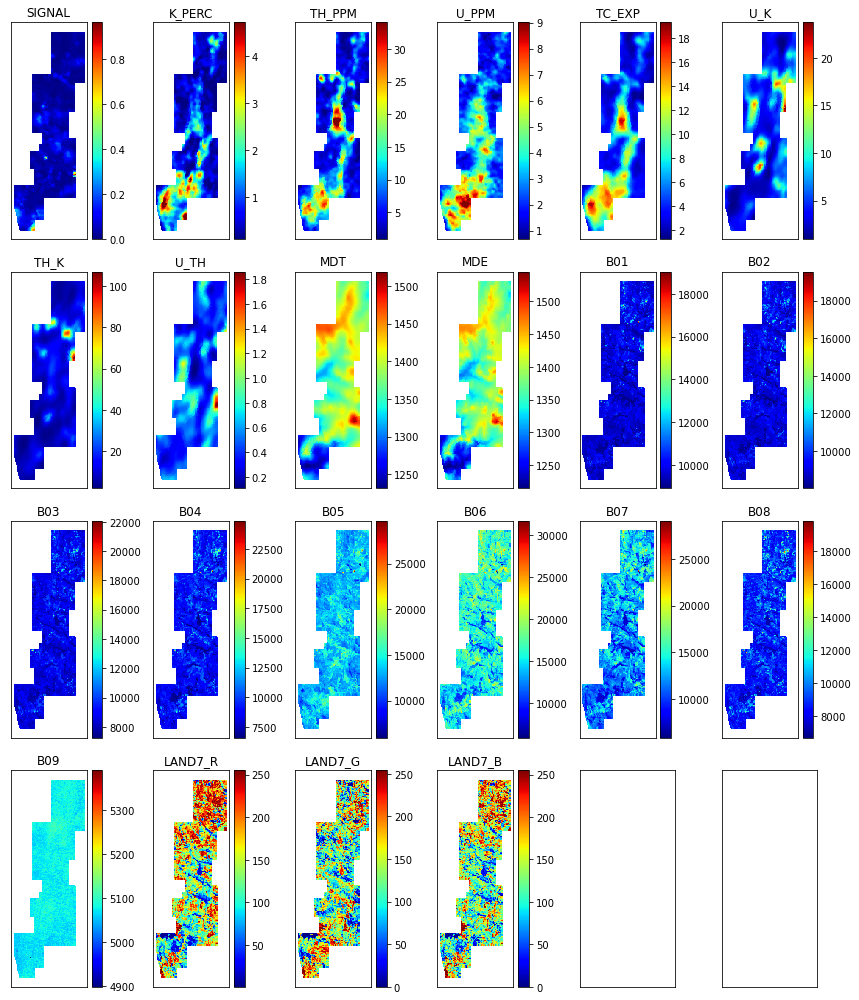

In [149]:
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(12, 14),
                        subplot_kw={'xticks': [], 'yticks': []})

X, Y = COORD[0], COORD[1]

for ax, f in zip(axs.flat, FEAT):
    g = ax.scatter(data=df, x = X, y = Y, c=f, cmap=cm, s = sz, marker = mk)
    fig.colorbar(g, ax = ax)
    ax.set_title(str(f))

plt.tight_layout();

### Descrição univariada

##### Estatísticas dos dados geofísicos

In [ ]:
sumStats(df = df[gf])

In [ ]:
df[gf].hist(edgecolor='black', color='orange', figsize=(9,9), grid=False);

- Todas as features geofísicas apresentam distribuições assimétricas positivas;

- As features geofísicas tendem a ser as mais erráticas do banco de dados, com destaque para `SIGNAL` que, por sua vez, apresenta um Cᵥ ~ 1.04.

##### Estatísticas dos sensores remotos

In [ ]:
sumStats(df = df[sr])

In [ ]:
df[sr].hist(edgecolor='black', color='orange', figsize=(12,12), grid=False);

- A grande maioria dos sensores remotos apresentam distribuições assimétricas positivas ou quase simétricas;

- Apenas três features apresentam distribuições assimétricas negativas: `MDE`, `MDT` e `LAND7_R`.

- Em geral, os sensores remotos tendem a ser pouco erráticos, com destaque para `B09` que, por sua vez, apresenta um Cᵥ ~ 0.03.

##### Análise da dispersão das features

In [ ]:
disp = sumStats(df = df[feat]).sort_values(by = 'Cᵥ', ascending = False)['Cᵥ']

plt.figure(figsize=(15,4))

plt.bar(x = disp.index, height = disp.values,
       color = "orange", edgecolor = "black")

plt.title("Dispersão das features",size = 14)
plt.xticks(rotation = 45)
plt.ylabel("Cᵥ",size = 12);

- Os sensores remotos tendem a ser muito pouco erráticos (Cᵥ < 0.2), com exceção das features `LAND7_R`, `LAND7_G` e `LAND7_B` que, por sua vez, encontram-se entre as 10 features mais erráticas;

- Os dados geofísicos são, em geral os que apresentam maior dispersão, com exceção da razão `U_TH`.

##### Gráfico de barras unidades litoestratigráficas

In [ ]:
# Criação de dataframe com as variáveis utilizadas nos gráfico
df_lito_count = pd.DataFrame(df['UNID'].value_counts()) # Criação do dataframe
total_lito_count = df['UNID'].value_counts().sum() # Contagem total
df_lito_count['UNID_PERC'] = (df_lito_count['UNID'] / total_lito_count) * 100 # Criação de coluna de frequência percentual
freq_abs = df_lito_count['UNID'] # Variável de frequência absoluta
freq_perc = df_lito_count['UNID_PERC'].round(2) # Variável de frequência percentual

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

# Gráfico frequência absoluta
ax1.barh(list(df_lito_count.index),
         freq_abs,
         color='orange',
         edgecolor='black')

for i, v in enumerate(freq_abs):
    ax1.text(v + 20, i, str(v), va='center', fontweight='bold')
    
plt.setp(ax1,title="Frequência Absoluta das Unidades Litoestratigráficas",
         xlabel="Frequência Absoluta")


# Gráfico frequência percentual
ax2.barh(list(df_lito_count.index),
         freq_perc,
         color='orange',
         edgecolor='black')

ax2.axes.get_yaxis().set_visible(False)

for i, v in enumerate(freq_perc):
    ax2.text(v + 0.25, i, str(v) + "%", va='center', fontweight='bold')
    
plt.setp(ax2,title="Frequência Percentual das Unidades Litoestratigráficas",
         xlabel="Frequência Percentual");

- As 3 unidades litoestratigráficas mais frequentes (`Fm_SJC_C`, `Fm_SB_E` e `Fm_BG`) representam mais de 70% do total de ocorrências;

- Portanto, as classes estão claramente desbalanceadas e algumas abordagens serão conduzidas posteriormente para lidar com esse problema.

### Descrição Bivariada

##### Mapas de calor - coeficiente de correlação de Spearman

In [ ]:
mx_spear = df[feat].corr(method='spearman').round(2)

mask = np.triu(np.ones_like(mx_spear, dtype=np.bool))

plt.figure(figsize=(15, 15))
plt.title ('Heatmap de correlação RANKEADA entre features', size=18)
ax = sns.heatmap(
                 mx_spear,
                 annot = True,
                 cmap = "coolwarm",
                 cbar = True,
                 mask=mask
                )

##### Mapas de calor - Coeficiente de Correlação de Pearson

In [ ]:
mx_pear = df[feat].corr().round(2)

mask = np.triu(np.ones_like(mx_pear, dtype=np.bool))

plt.figure(figsize=(15, 15))
plt.title ('Heatmap de correlação LINEAR entre features', size=18)
ax = sns.heatmap(
                 mx_pear,
                 annot = True,
                 cmap = "coolwarm",
                 cbar = True,
                 mask=mask
                )

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam correlações lineares positivas médias a fortes entre si;

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam forte correlação linear positiva com a variável `TC_EXP`, o que já era esperado;

- A feature `SIGNAL` não apresenta correlação (linear ou monotônica) significativa com nenhuma outra feature;

- As features Landsat 8 apresentam fortíssimas correlações lineares entre si. Esse fato pode implicar em multicolinearidade e deve ser tratado cautelosamente caso um algoritmo linear seja utilizado.As únicas exceções são `B05` e `B09`;

- As features `MDE` e `MDT` são particamente idênticas. Apenas uma delas deve ser selecionada para treinar os algoritmos;

- A feature `MDT` apresenta uma correlação linear negativa média com `U_PPM`. Esse fato é interessante e deve ser investigado!

##### Features geofísicas x target

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(12,11))

sns.boxplot(y='SIGNAL', x='UNID', data=df, ax=ax1)
sns.boxplot(y='U_PPM', x='UNID', data=df, ax=ax2)
sns.boxplot(y='K_PERC', x='UNID', data=df, ax=ax3)
sns.boxplot(y='TH_PPM', x='UNID', data=df, ax=ax4)
sns.boxplot(y='TC_EXP', x='UNID', data=df, ax=ax5)

plt.setp((ax1,ax2,ax3,ax4, ax5), xlabel='')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False);

##### Features Landsat 8 x target

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(9,1,figsize=(12,24))

sns.boxplot(x='UNID', y='B01', data=df, ax=ax1)
sns.boxplot(x='UNID', y='B02', data=df, ax=ax2)
sns.boxplot(x='UNID', y='B03', data=df, ax=ax3)
sns.boxplot(x='UNID', y='B04', data=df, ax=ax4)
sns.boxplot(x='UNID', y='B05', data=df, ax=ax5)
sns.boxplot(x='UNID', y='B06', data=df, ax=ax6)
sns.boxplot(x='UNID', y='B07', data=df, ax=ax7)
sns.boxplot(x='UNID', y='B08', data=df, ax=ax8)
sns.boxplot(x='UNID', y='B09', data=df, ax=ax9)

plt.setp((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9), xlabel='')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False)
ax5.axes.get_xaxis().set_visible(False)
ax6.axes.get_xaxis().set_visible(False)
ax7.axes.get_xaxis().set_visible(False)
ax8.axes.get_xaxis().set_visible(False);

##### Outros sensores remotos x features

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(12,11))

sns.boxplot(y='MDE', x='UNID', data=df, ax=ax1)
sns.boxplot(y='MDT', x='UNID', data=df, ax=ax2)
sns.boxplot(y='LAND7_R', x='UNID', data=df, ax=ax3)
sns.boxplot(y='LAND7_G', x='UNID', data=df, ax=ax4)
sns.boxplot(y='LAND7_B', x='UNID', data=df, ax=ax5)

plt.setp((ax1,ax2,ax3,ax4, ax5), xlabel='')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False);

- As features Landsat 8 apresentam uma variabilidade extremamente baixa quando agrupadas por unidades litoestratigráficas. Nesse sentido, possivelmente, essas variáveis não serão úteis para treinar os modelos;

- Em contrapartida, as features geofísicas, juntamente com `MDE` / `MDT`, `LAND7_R`, `LAND7_G` e `LAND7_B`, apresentam uma dispersão significativa quando agrupadas pelas unidades. Essas variáveis possivelmente contribuirão positivamente para as predições.

##### Estatísticas de K (%) por unidade litoestratigráfica

In [ ]:
df[['UNID', 'K_PERC']].groupby(by='UNID').describe(percentiles=[0.1,0.995]).T

In [ ]:
df['K_PERC'].hist(by=df['UNID'], figsize=(9, 9), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `K_PERC` são **Fm_SB_D** e **Fm_SJC_B**;

- As unidades que apresentam MENORES concentrações de `K_PERC` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de U (ppm) por unidade litoestratigráfica

In [ ]:
df[['UNID', 'U_PPM']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

In [ ]:
df['U_PPM'].hist(by=df['UNID'], figsize=(9, 9), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `U_PPM` são **Cx_GG** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `U_PPM` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de Th (ppm) por unidade litoestratigráfica

In [ ]:
df[['UNID', 'TH_PPM']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

In [ ]:
df['TH_PPM'].hist(by=df['UNID'], figsize=(9, 9), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `TH_PPM` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM`);

- As unidades que apresentam MENORES concentrações de `TH_PPM` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM`).

##### Estatísticas de contagem total (μR/h) por unidade litoestratigráfica

In [ ]:
df[['UNID', 'TC_EXP']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

In [ ]:
df['TC_EXP'].hist(by=df['UNID'], figsize=(10, 12), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `TC_EXP` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM` e `TH_PPM`);

- As unidades que apresentam MENORES concentrações de `TC_EXP` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM` e `TH_PPM`);

- OBS.: a distribuição uniforme apresentada por **Sm_CMD** ocorre em função da baixa densidade amostral dessa unidade (10 valores e 10 *bins*).

##### Estatísticas de sinal análitico (nT/m) por unidade litoestratigráfica

In [ ]:
df[['UNID', 'SIGNAL']].groupby(by='UNID').describe(percentiles=[0.1,0.9]).T

In [ ]:
df['SIGNAL'].hist(by=df['UNID'], figsize=(10, 12), edgecolor='black', color='orange');

- As unidades que apresentam MAIORES concentrações de `SIGNAL` são **Fm_SB_D** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `SIGNAL` são **Fm_SB_F** e **Sm_PL**.